# Chapter 3 - Exercises

## Exercise 1 - MNIST accuracy > 97%

### 1. Explore the dataset

In [21]:
# Load MNIST from sklearn

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

c:\Users\faguilera\miniconda3\envs\ml\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [22]:
X, y = mnist["data"], mnist["target"]
X = X.values
y = y.values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [23]:
from matplotlib import pyplot as plt

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.scatter(14, 14, c='red')
    plt.imshow(image, cmap = plt.cm.binary,
               interpolation="nearest")

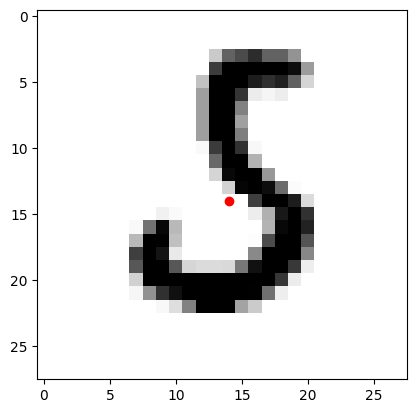

In [24]:
import numpy as np
rand_digit_index = np.random.randint(0, len(X))
plot_digit(X[rand_digit_index])

In [25]:
y[rand_digit_index]

'5'

### 2. Split into training and test sets. Stratified by label

In [26]:
# Split the data into train and test equally
# There must be same proportion of each digit in train and test

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [27]:
# Lengths
print(len(X_train))
print(len(X_test))

60000
10000


In [28]:
def print_proportions(y):
    for i in range(10):
        print("Proportion of", i, ":", len(y[y == str(i)]) / len(y))

print_proportions(y_train)
print_proportions(y_test)

Proportion of 0 : 0.09871666666666666
Proportion of 1 : 0.11236666666666667
Proportion of 2 : 0.0993
Proportion of 3 : 0.10218333333333333
Proportion of 4 : 0.09736666666666667
Proportion of 5 : 0.09035
Proportion of 6 : 0.09863333333333334
Proportion of 7 : 0.10441666666666667
Proportion of 8 : 0.09751666666666667
Proportion of 9 : 0.09915
Proportion of 0 : 0.098
Proportion of 1 : 0.1135
Proportion of 2 : 0.1032
Proportion of 3 : 0.101
Proportion of 4 : 0.0982
Proportion of 5 : 0.0892
Proportion of 6 : 0.0958
Proportion of 7 : 0.1028
Proportion of 8 : 0.0974
Proportion of 9 : 0.1009


### 3. Pipeline steps

#### Center digits in image

In [29]:
# We want to center the MNIST digits in the center of the image
# First we need to find the center of mass of each digit
# Then we need to shift the image so that the center of mass is in the center of the image
# Keep dimensions and np arrays in mind    

def center_image(digit):
    # Digit is ndarray. Convert to 28x28
    digit = digit.reshape(28, 28)
    
    # Get bounding box of digit
    # Find the first and last row and column that has a non-zero value
    min_x, min_y, max_x, max_y = 28, 28, 0, 0

    for x in range(28):
        for y in range(28):
            if digit[x][y] != 0:
                if x < min_x:
                    min_x = x
                if x > max_x:
                    max_x = x
                if y < min_y:
                    min_y = y
                if y > max_y:
                    max_y = y

    # Get center of bounding box
    center_x = (min_x + max_x) / 2
    center_y = (min_y + max_y) / 2

    # Get center of image
    center_x_img = digit.shape[0] / 2
    center_y_img = digit.shape[1] / 2

    # Get difference between center of bounding box and center of image
    diff_x = center_x_img - center_x
    diff_y = center_y_img - center_y

    # Shift image by difference
    # Create new image
    centered = np.zeros((28, 28))

    # Copy digit to new image
    for x in range(28):
        for y in range(28):
            if digit[x][y] != 0:
                centered[int(x + diff_x)][int(y + diff_y)] = digit[x][y]

    return centered.reshape(784)

In [30]:
def plot_centered(X, X_centered):
    rand_idx = np.random.randint(0, len(X))
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(X[rand_idx].reshape(28, 28), cmap = plt.cm.binary,
                    interpolation="nearest")
    axs[1].imshow(X_centered[rand_idx].reshape(28,28), cmap = plt.cm.binary,
                    interpolation="nearest")

In [31]:
# Create transformer to center images with option
from sklearn.base import BaseEstimator, TransformerMixin

class CenterImage(BaseEstimator, TransformerMixin):
    def __init__(self, center=True):
        self.center = center
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if self.center:
            return np.apply_along_axis(center_image, 1, X)
        else:
            return X

In [32]:
# Plot test 
center_image_transformer = CenterImage()
X_train_centered = center_image_transformer.fit_transform(X_train)
X_test_centered = center_image_transformer.transform(X_test)

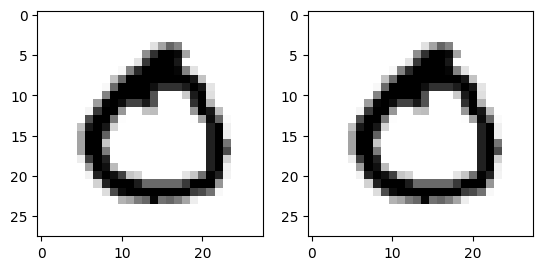

In [33]:
plot_centered(X_train, X_train_centered)

#### Scale data to [0, 1]

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
mnist_scaler = scaler.fit(X_train_centered.astype(np.float64))

### Pipeline

In [35]:
# pipeline
from sklearn.pipeline import Pipeline

mnist_pipeline = Pipeline([
    ('center_image', CenterImage()),
    ('scaler', StandardScaler())
])

x_prepared = mnist_pipeline.fit_transform(X_train)

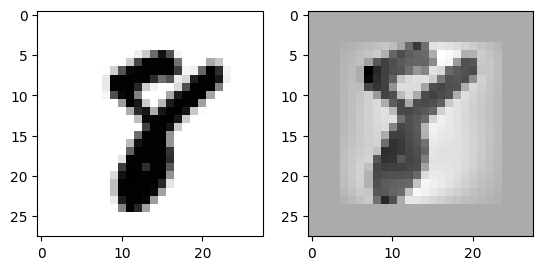

In [36]:
plot_centered(X_train, x_prepared)

## Train model: KNeighborsClassifier

In [63]:
# KNeighborsClassifier param grid search.
# OneVSAllClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

knn_clf = KNeighborsClassifier()

ova_clf = OneVsRestClassifier(knn_clf)

param_grid = [
    {'n_neighbors': [3, 5], 'weights': ['uniform', 'distance']}
]

grid_search = GridSearchCV(ova_clf, param_grid, cv=3, verbose=10, n_jobs=-1)
grid_search.fit(x_prepared, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


ValueError: Invalid parameter 'n_neighbors' for estimator OneVsRestClassifier(estimator=KNeighborsClassifier()). Valid parameters are: ['estimator', 'n_jobs', 'verbose'].

In [38]:
grid_search.best_params_

{'n_neighbors': 3, 'weights': 'distance'}

## Measure performance

In [39]:
# Performance with best params with cross validation
from sklearn.model_selection import cross_val_score
    
best_model = grid_search.best_estimator_
cross_val_score(best_model, x_prepared, y_train, cv=3, scoring='accuracy', verbose=10, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.6min finished


array([0.9522 , 0.95305, 0.9542 ])

In [40]:
# Measure performance on test set
x_test_prepared = mnist_pipeline.transform(X_test)
best_model.score(x_test_prepared, y_test)

# Measure performance on test set with cross validation
cross_val_score(best_model, x_test_prepared, y_test, cv=3, scoring='accuracy', verbose=10, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.0s finished


array([0.8785243 , 0.90909091, 0.93219322])

### Precision and recall

In [41]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = best_model.predict(x_test_prepared)
confusion_matrix(y_test, y_pred)

array([[ 975,    0,    0,    0,    0,    2,    3,    0,    0,    0],
       [   0, 1130,    3,    0,    0,    0,    1,    1,    0,    0],
       [  15,   10,  961,    4,    1,    2,    1,   31,    5,    2],
       [   0,    0,    3,  982,    0,    5,    0,    7,    8,    5],
       [   2,   18,    5,    0,  910,    0,    4,    5,    2,   36],
       [   6,    0,    0,   22,    1,  845,    7,    4,    5,    2],
       [   7,    4,    0,    0,    2,    2,  943,    0,    0,    0],
       [   1,   21,    4,    0,    8,    0,    1,  981,    0,   12],
       [   3,    1,    5,   24,    3,   21,    9,    8,  886,   14],
       [   6,   10,    3,    7,    9,    4,    0,   12,    1,  957]],
      dtype=int64)

In [42]:
print("Model precision:", precision_score(y_test, y_pred, average="macro"))
print("Model recall:", recall_score(y_test, y_pred, average="macro"))

Model precision: 0.9578321951698291
Model recall: 0.9564698397584754


In [60]:
# confusion matrix

from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_test, y_pred)
conf_mx

array([[ 975,    0,    0,    0,    0,    2,    3,    0,    0,    0],
       [   0, 1130,    3,    0,    0,    0,    1,    1,    0,    0],
       [  15,   10,  961,    4,    1,    2,    1,   31,    5,    2],
       [   0,    0,    3,  982,    0,    5,    0,    7,    8,    5],
       [   2,   18,    5,    0,  910,    0,    4,    5,    2,   36],
       [   6,    0,    0,   22,    1,  845,    7,    4,    5,    2],
       [   7,    4,    0,    0,    2,    2,  943,    0,    0,    0],
       [   1,   21,    4,    0,    8,    0,    1,  981,    0,   12],
       [   3,    1,    5,   24,    3,   21,    9,    8,  886,   14],
       [   6,   10,    3,    7,    9,    4,    0,   12,    1,  957]],
      dtype=int64)

In [62]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred)

ValueError: multiclass format is not supported